# Land Cover Classification using Deep Learning Techniques and EuroSAT

### Testing for CS294-82 Project
### Simona Aksman

## Mounting google drive for dataset access and saving models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from tqdm.notebook import tqdm
import seaborn as sns


from sklearn.metrics import confusion_matrix
from sklearn import model_selection

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import transforms
from torchvision.utils import make_grid
import torch.nn.functional as F
import tensorflow as tf
import tensorflow_datasets as tfds

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /drive/CS29482/data/eurosat/rgb/2.0.0.incompleteNWA2B6/eurosat-train.tfrecord


  0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to /drive/CS29482/data/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


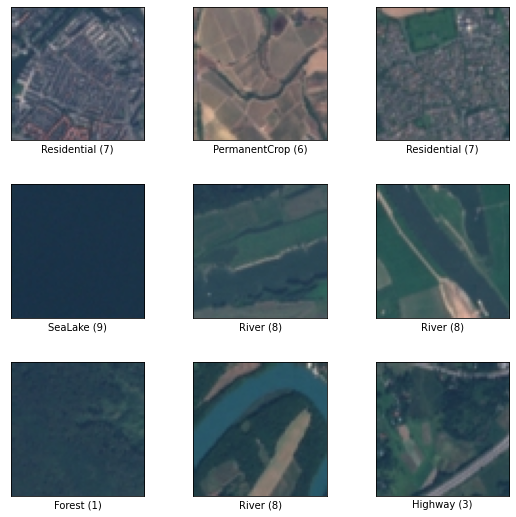

In [ ]:
# TODO: store data in GDrive instead of loading it from here every time
# RGB data
DATA_DIR = '/drive/MyDrive/CS29482/data/'

ds, ds_info = tfds.load('eurosat/rgb',
                        with_info=True,
                        split='train',
                        data_dir=DATA_DIR)
ds_df = tfds.as_dataframe(ds, ds_info)
tfds.show_examples(ds, ds_info);

In [ ]:
# TODO: store data in GDrive
# All 13 spectral bands
ds_all, ds_all_info = tfds.load('eurosat/all',
                        with_info=True,
                        split='train',
                        data_dir=DATA_DIR)
ds_all_df = tfds.as_dataframe(ds_all, ds_all_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to ./eurosat/all/2.0.0.incompleteUUGPL9/eurosat-train.tfrecord


  0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to ./eurosat/all/2.0.0. Subsequent calls will reuse this data.


## Config

In [ ]:
# ROOT_PATH = '.'
# BASE_PATH = os.path.join(ROOT_PATH, 'Image_Dataset')
# DATA_PATH = os.path.join(ROOT_PATH, 'Dataset')
# FULL_DATA_DF = os.path.join(ROOT_PATH, 'FULL_DATA.csv')

# if not os.path.isdir(DATA_PATH):
#     os.mkdir(DATA_PATH)

IDX_CLASS_LABELS = {
    0: 'AnnualCrop',
    1: 'Forest', 
    2: 'HerbaceousVegetation',
    3: 'Highway',
    4: 'Industrial',
    5: 'Pasture',
    6: 'PermanentCrop',
    7: 'Residential',
    8: 'River',
    9: 'SeaLake'
}
CLASSES = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture','PermanentCrop','Residential','River', 'SeaLake']
CLASS_IDX_LABELS = dict()
for key, val in IDX_CLASS_LABELS.items():
  CLASS_IDX_LABELS[val] = key

NUM_CLASSES = len(IDX_CLASS_LABELS.items())
torch.manual_seed(10)
VALID_SIZE = 0.2


## Utils

In [ ]:
## Give idx of each class name
def encode_label(label):
    idx = CLASS_IDX_LABELS[label] 
    return idx

## Take in idx and return the class name
def decode_target(target, text_labels=True):
    result = []
    if text_labels:
        return IDX_CLASS_LABELS[target]
    else:
        return target

## Show batches of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [ ]:
## Example for decoding and encoding
print(encode_label('Forest'), decode_target(2))
print(decode_target(2, text_labels=True))

1 HerbaceousVegetation
HerbaceousVegetation


## Pre-Processing data folders to train and test
Run this code cells only if you don't have the required dataframe

In [ ]:
# from os import walk
# i = 0
# for (dirpath, dirname, filename) in walk(BASE_PATH):
#   print("Directory Path: ", dirpath)
#   print("Directory Name: ", dirname)
#   print("Filename : ", filename)
#   print("----------------------"*10)
#   i += 1
#   if i > 3:
#     break

In [ ]:
# from os import walk

# i = 0
# DATA_DF = pd.DataFrame(columns = ['image_id', 'label']) 

# for (dirpath, dirname, filename) in walk(BASE_PATH):
#   for each_file in filename:
#     DATA_DF.loc[i] = [each_file, dirpath.split('/')[-1]]
#     i += 1
#   # break
# DATA_DF.to_csv(FULL_DATA_DF, index=False)
# DATA_DF.head()


## Processing data folders to train and test


In [ ]:
DATA_DF = ds_df
DATA_DF['filename'].str.decode("utf-8")
print(DATA_DF.shape)

(27000, 3)


In [ ]:
DATA_DF = DATA_DF.sample(frac = 1, random_state=48) 
print(DATA_DF.shape)
TRAIN_DF = DATA_DF[:-int(len(DATA_DF)*VALID_SIZE)]
VALID_DF = DATA_DF[-int(len(DATA_DF)*VALID_SIZE) :]

(27000, 3)


In [ ]:
ds_all_ims = np.array(ds_all_df['sentinel2'])

In [ ]:
ds_all_df['sentinel2'].shape

(27000,)

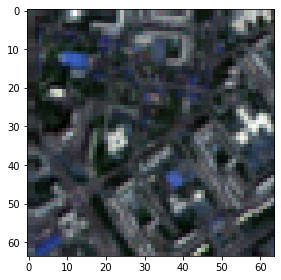

In [ ]:
# B01 - Aerosols 60 443
# B02 - Blue 10 490
# B03 - Green 10 560
# B04 - Red 10 665
# B05 - Red edge 1 20 705
# B06 - Red edge 2 20 740
# B07 - Red edge 3 20 783
# B08 - NIR 10 842
# B08A - Red edge 4 20 865
# B09 - Water vapor 60 945
# B10 - Cirrus 60 1375
# B11 - SWIR 1 20 1610
# B12 - SWIR 2 20 2190
import skimage.io as skio

def min_max_norm(im):
    '''
    Normalizes an image's pixel intensity using min max normalization
    
    Parameters
    ----------
    im : array
    
    Returns
    -------
    im : array
    '''
    return (im - im.min()) / (im.max() - im.min())


b2 = ds_all_ims[8][:,:,1]
b3 = ds_all_ims[8][:,:,2]
b4 = ds_all_ims[8][:,:,3]

b2_max = b2.max()
b3_max = b3.max()
b4_max = b4.max()


rgb_example_from_all = np.dstack([min_max_norm(b2), min_max_norm(b3), min_max_norm(b4)])
# skio.imshow(ds_df['image'][0])
# skio.show()
skio.imshow(rgb_example_from_all)
skio.show()


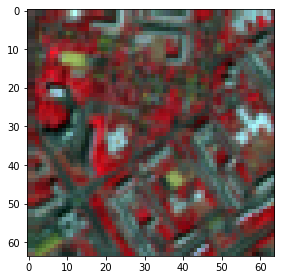

In [ ]:
# CIR
# Red (B4), Green (B3), Near-Infrared (B8)

b8 = ds_all_ims[8][:,:,7]
b3 = ds_all_ims[8][:,:,2]
b4 = ds_all_ims[8][:,:,3]

b8_max = b8.max()
b3_max = b3.max()
b4_max = b4.max()

cir_example_from_all = np.dstack([min_max_norm(b8), min_max_norm(b4), min_max_norm(b3)])
# skio.imshow(ds_df['image'][0])
# skio.show()
skio.imshow(cir_example_from_all)
skio.show()

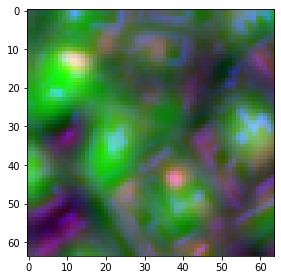

In [ ]:
# SWIR
# Red Edge 4 (B8A), Red (B4), Shortwave-Infrared (B12)


b8a = ds_all_ims[8][:,:,8]
b12 = ds_all_ims[8][:,:,11]
b4 = ds_all_ims[8][:,:,3]

b8a_max = b8a.max()
b12_max = b12.max()
b4_max = b4.max()

swir_example_from_all = np.dstack([min_max_norm(b12), min_max_norm(b8a), min_max_norm(b4)])
# skio.imshow(ds_df['image'][0])
# skio.show()
skio.imshow(swir_example_from_all)
skio.show()

In [ ]:
cir_example_from_all.min(), cir_example_from_all.max()

(0.0, 1.0)

In [ ]:
swir_example_from_all.min(), swir_example_from_all.max()

(0.0, 1.0)

In [ ]:
ds_df['image'][0].shape

(64, 64, 3)

In [ ]:
ds_df.head()

,filename,image,label
0,b'Residential_397.jpg',"[[[47, 71, 83], [48, 70, 83], [57, 77, 88], [5...",7
1,b'AnnualCrop_825.jpg',"[[[150, 131, 133], [147, 131, 132], [146, 130,...",0
2,b'PermanentCrop_818.jpg',"[[[56, 89, 78], [56, 87, 79], [47, 76, 71], [5...",6
3,b'SeaLake_53.jpg',"[[[52, 82, 93], [53, 83, 94], [55, 81, 94], [5...",9
4,b'AnnualCrop_387.jpg',"[[[224, 181, 165], [223, 180, 164], [228, 182,...",0


In [ ]:
DATA_DF.to_csv('/content/drive/MyDrive/CS29482/rgb_10class.csv', columns = ['image', 'label'], index = False)

In [ ]:
!brainome '/content/drive/MyDrive/CS29482/rgb_10class.csv' -y -target label -measureonly -o rgb_10class_measurement_script.py


Brainome Table Compiler v1.006-82-prod
Copyright (c) 2019-2021 Brainome, Inc. All Rights Reserved.
Licensed to:                 y Demo User  (Evaluation)
Expiration Date:             2021-12-12   35 days left
Maximum File Size:           100 MB
Maximum Instances:           20000
Maximum Attributes:          100
Maximum Classes:             unlimited
Connected to:                daimensions.brainome.ai  (local execution)

Command:
    btc /content/drive/MyDrive/CS29482/rgb_10class.csv -y -target label -measureonly -o rgb_10class_measurement_script.py

Start Time:                 11/07/2021, 17:33 UTC

Cleaning...-/|\-done. 
Splitting into training and validation...-/|\-/|\-/done. 
Pre-training measurements...-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/

In [ ]:
!brainome '/content/drive/MyDrive/CS29482/rgb_10class.csv' -f NN -y -target label -o rgb_10class_script.py | grep MEC

Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='UTF-8'>
BrokenPipeError: [Errno 32] Broken pipe


In [ ]:
DATA_DF.groupby('label').count()

,filename,image
label,,
0,3000,3000
1,3000,3000
2,3000,3000
3,2500,2500
4,2500,2500
5,2000,2000
6,2500,2500
7,3000,3000
8,2500,2500


In [ ]:
TRAIN_DF.reset_index(inplace = True) 
TRAIN_DF.head()

,index,filename,image,label
0,19127,b'Highway_597.jpg',"[[[39, 63, 75], [40, 64, 74], [54, 79, 83], [8...",3
1,3197,b'Forest_1878.jpg',"[[[48, 76, 79], [46, 76, 78], [45, 75, 77], [4...",1
2,24557,b'HerbaceousVegetation_1630.jpg',"[[[94, 99, 93], [95, 100, 94], [103, 104, 99],...",2
3,17042,b'AnnualCrop_2996.jpg',"[[[223, 170, 156], [222, 169, 155], [225, 169,...",0
4,3697,b'PermanentCrop_1013.jpg',"[[[147, 123, 123], [148, 122, 123], [161, 131,...",6


In [ ]:
VALID_DF.reset_index(inplace = True) 
VALID_DF.head()

,index,filename,image,label
0,5675,b'PermanentCrop_109.jpg',"[[[76, 86, 95], [76, 85, 94], [85, 88, 97], [8...",6
1,16156,b'Highway_2320.jpg',"[[[43, 66, 84], [44, 67, 85], [45, 68, 86], [4...",3
2,7010,b'Industrial_384.jpg',"[[[37, 72, 78], [37, 70, 77], [38, 68, 79], [3...",4
3,10362,b'Residential_92.jpg',"[[[42, 68, 81], [43, 69, 82], [44, 72, 86], [4...",7
4,12895,b'PermanentCrop_1484.jpg',"[[[153, 146, 140], [151, 142, 135], [151, 140,...",6


In [ ]:
TRAIN_DF.size, VALID_DF.size

(86400, 21600)

## Creating Dataset and Dataloaders

Now we will Create custom dataset by extending pytorch Dataset class. We also add provision for adding transformers for data augmentation.

In [ ]:
import torchvision.transforms as transforms

class EuroSAT(Dataset):
    def __init__(self, train_df, train_dir, transform=None):
        self.train_dir = train_dir
        self.train_df = train_df
        self.transform = transform
        
    def __len__(self):
        return len(self.train_df)
    
    def __getitem__(self, idx):
        row = self.train_df.loc[idx]
        img_id, label = row['filename'], decode_target(row['label'])
        img = transforms.ToPILImage()(row['image'])
        if self.transform:
            img = self.transform(img)
        return img, encode_label(label)

### Transformations and Datasets

In [ ]:
## Dataset and transformations
data_transform = transforms.Compose([
                                transforms.Resize(size=(224, 224)),
#                                 transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
train_ds = EuroSAT(TRAIN_DF, '.', data_transform)
valid_ds = EuroSAT(VALID_DF, '.', data_transform)
print(len(train_ds), len(valid_ds))

21600 5400


In [ ]:
## Data loaders and showing batch of data
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=False, num_workers=2, pin_memory=True)
# show_batch(train_dl)

## Model

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

class MulticlassClassifierBase(nn.Module):
    
    def training_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return accu ,loss
    def validation_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return {"val_loss": loss.detach(), "val_acc": accu}
    
    def validation_epoch_ends(self, outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss":epoch_loss.item(), "val_acc":epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}],train_accu: {:.4f}, learning_rate: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,result['train_accu'], result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class LULC_Model(MulticlassClassifierBase):
    def __init__(self):
        super().__init__()
        self.network = models.wide_resnet50_2(pretrained=True)
        n_inputs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
                              nn.Linear(n_inputs, 256),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(256, NUM_CLASSES),
                              nn.LogSoftmax(dim=1)
                                )
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        for param in self.network.parameters():
            param.require_grad=False
        for param in self.network.fc.parameters():
            param.require_grad=True
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad=True

In [ ]:
model = LULC_Model()

In [ ]:
## Running through the data loader => Model => Output
def try_batch(dl):
  for images, labels in dl:  
    print(images.shape)
    out = model(images)
    print(out.shape)
    print(out[0])
    break

try_batch(train_dl)

KeyError: ignored

## Training and Evaluating

In [ ]:
@torch.no_grad()
def evaluate(model, valid_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_loader]
    return model.validation_epoch_ends(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit(epochs, max_lr,  model, train_loader, valid_loader, weight_decay=0,\
                grad_clip=None,opt_func=torch.optim.SGD, max_epochs_stop=3):
  
    history = []
    valid_loss_min = np.Inf
    valid_acc_max = 0
    model_file_name = 'lulc.pth'
    model_file_name2 = 'lulc_max_acc.pth'
    epochs_no_improve =  0
    optimizer = opt_func(model.parameters(), lr=max_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.00001)
                         
    for epoch in range(epochs):
        model.train()
        train_loss = []
        train_accu = []
        lrs = []
        for batch in tqdm(train_loader):
            
            accu, loss = model.training_step(batch)
            train_loss.append(loss)
            train_accu.append(accu)
            loss.backward()
            ## Gradient Clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            
            
            
        result = evaluate(model, valid_loader)
        scheduler.step(result['val_loss'])
        ########### Early Stopping ##############                                         
        valid_loss = result['val_loss']
        valid_acc = result['val_acc']
        if valid_acc > valid_acc_max:
            torch.save(model.state_dict(), model_file_name2)
            valid_acc_max = valid_acc
        if valid_loss<valid_loss_min:
            torch.save(model.state_dict(), model_file_name)
            valid_loss_min = valid_loss                                  
            epochs_no_improve = 0          
        else:
            epochs_no_improve += 1
            if epochs_no_improve > max_epochs_stop:
                result["train_loss"] = torch.stack(train_loss).mean().item()
                result["train_accu"] = torch.stack(train_accu).mean().item()
                result["lrs"] = lrs
                model.epoch_end(epoch, result)
                history.append(result)
                print("Early Stopping............................")
                return history                                
                                                 
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["train_accu"] = torch.stack(train_accu).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    print("VAL LOSS MIN {}".format(valid_loss_min))
    print("VAL ACC MAX {}".format(valid_acc_max))
    return history

## Initializing Device also Loading Data and Model to device¶


In [ ]:
def get_device():
    print(torch.cuda.is_available())
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_device()
## Loading data to devide
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
## Loading model to device
model = to_device(LULC_Model(), device)
## lets try passing a batch to model again
# try_batch(train_dl)

True


In [ ]:
torch.cuda.empty_cache()

## Training

In [ ]:
## Hyper Parameters
max_epochs_stop = 10
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
epochs = 10
opt_func = torch.optim.Adam
## Evaluating with non-trained model
evaluate(model, valid_dl)

KeyError: ignored

In [ ]:
## Freezing except last layer
model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

## Reports

### Training Reports

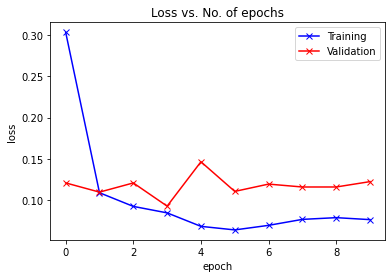

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

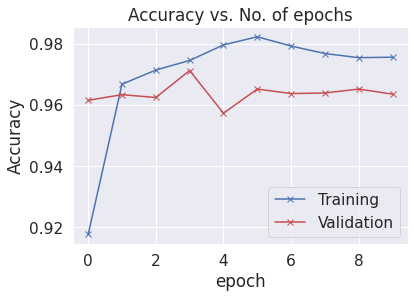

In [ ]:
def plot_accuracy(history):
        
    train_accu = [x.get('train_accu') for x in history]
    val_accu = [x['val_acc'] for x in history]
    plt.plot(train_accu, '-bx')
    plt.plot(val_accu, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');
plot_accuracy(history)

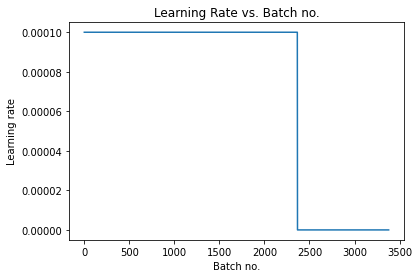

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
    
plot_lrs(history)

### Prediction Reports

In [ ]:
def show_sample(img, target=None):
    if target:
        print("Label" ,decode_target(int(target), text_labels=True))
    plt.imshow(img.permute(1, 2, 0))

### Predict Single Images
def predict_single(image):
    show_sample(image)
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    _, prediction = torch.max(preds.cpu().detach(), dim=1)
    return decode_target(int(prediction), text_labels=True)


'River'

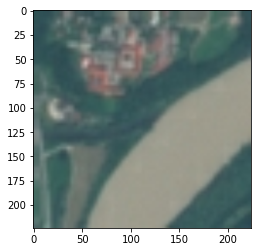

In [ ]:
predict_single(valid_ds[40][0])

'Residential'

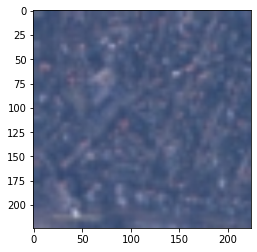

In [ ]:
predict_single(valid_ds[30][0])

'AnnualCrop'

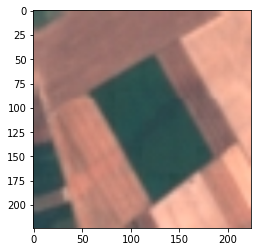

In [ ]:
predict_single(valid_ds[90][0])

## Evaluation on whole dataset

In [ ]:
batch_size =1
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_pred, labels = [], []
    for xb, label in tqdm(dl):
        probs = model(xb)
        _, pred = torch.max(probs.cpu().detach(), dim=1)
        batch_pred.append(pred.cpu().detach())     
        labels.append(label)   
    return [x for x in batch_pred], \
            [x for x in labels]

In [ ]:

## Accuracy Evaluation
def final_accuracy(predictions, labels):
  predictions = to_device(predictions, device)
  labels = to_device(labels, device)
  ## Total Accuracy
  total = 0
  for i in range(len(predictions)):
    if predictions[i] == labels[i]:
      total += 1
  acc = total/len(predictions)
  print(acc)

In [ ]:
full_ds = EuroSAT(DATA_DF, '.', data_transform)
full_dl = DataLoader(full_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
device = get_device()
## Loading data to devide
full_dl = DeviceDataLoader(full_dl, device)


True


In [ ]:
predictions, labels = predict_dl(full_dl, model)
final_accuracy(predictions, labels)
preds = [x.item() for x in predictions]
labs = [x.item() for x in labels]
cm = confusion_matrix(preds, labs)
cm

  0%|          | 0/27000 [00:00<?, ?it/s]

0.9805555555555555


array([[2977,    0,    5,    6,    2,   15,  172,    0,    4,    1],
       [   1, 2998,    3,    1,    0,    9,    0,    0,    0,    0],
       [   4,    2, 2987,    3,    0,   27,  117,    0,   10,    0],
       [   3,    0,    0, 2465,    0,    2,    2,    1,   25,    1],
       [   0,    0,    0,   14, 2486,    0,    1,    4,    6,    0],
       [   4,    0,    3,    2,    0, 1939,    7,    0,   12,    0],
       [   0,    0,    2,    6,    6,    0, 2199,    0,    1,    0],
       [   0,    0,    0,    0,    6,    0,    1, 2995,    1,    0],
       [   4,    0,    0,    3,    0,    5,    1,    0, 2435,    4],
       [   7,    0,    0,    0,    0,    3,    0,    0,    6, 2994]])

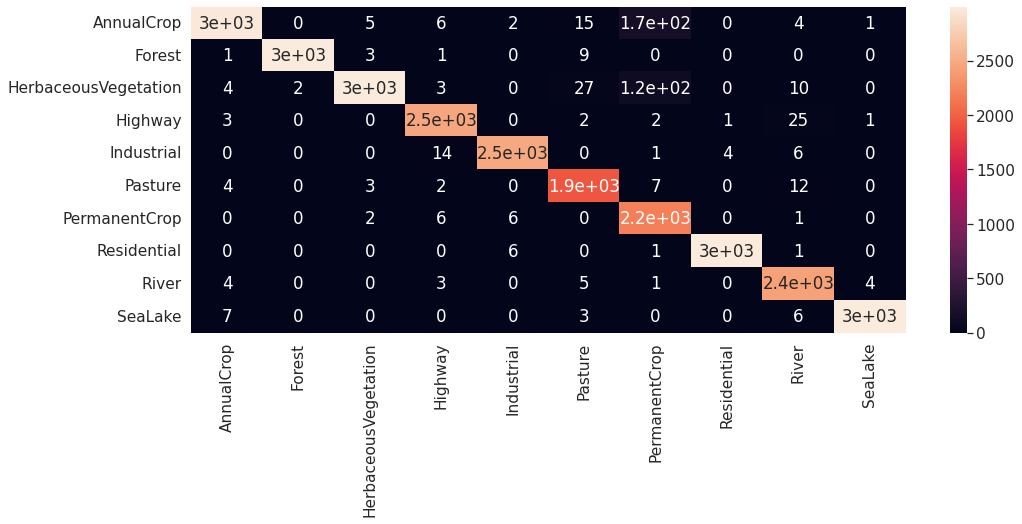

In [ ]:
## Plotting Confusion matrix
df_cm = pd.DataFrame(cm, CLASSES, CLASSES)
sns.set(font_scale=1.4) # for label size
plt.figure(figsize = (16,6))
sns.heatmap(df_cm, annot=True)

In [ ]:
## Evaluation with best validation accuracy model
model = LULC_Model()
model.load_state_dict(torch.load("/content/lulc_max_acc.pth"))
model.eval()
model = to_device(model, device)
predictions, labels = predict_dl(full_dl, model)
final_accuracy(predictions, labels)
preds = [x.item() for x in predictions]
labs = [x.item() for x in labels]
cm = confusion_matrix(preds, labs)
cm

  0%|          | 0/27000 [00:00<?, ?it/s]

0.985037037037037


array([[2966,    0,    2,    3,    0,    4,   16,    0,    8,    5],
       [   0, 2984,    1,    1,    0,    0,    1,    1,    0,    0],
       [   2,    4, 2973,    0,    0,   15,   69,    0,    0,    0],
       [   0,    0,    0, 2478,    2,    0,    0,    0,   16,    0],
       [   0,    0,    0,    5, 2432,    0,   57,    0,    2,    0],
       [  16,    7,   11,    1,    0, 1981,   12,    0,   20,    3],
       [   7,    0,    2,    1,    0,    0, 2341,    0,    0,    0],
       [   0,    0,    1,    5,   66,    0,    2, 2999,    1,    0],
       [   4,    4,    6,    6,    0,    0,    2,    0, 2451,    1],
       [   5,    1,    4,    0,    0,    0,    0,    0,    2, 2991]])

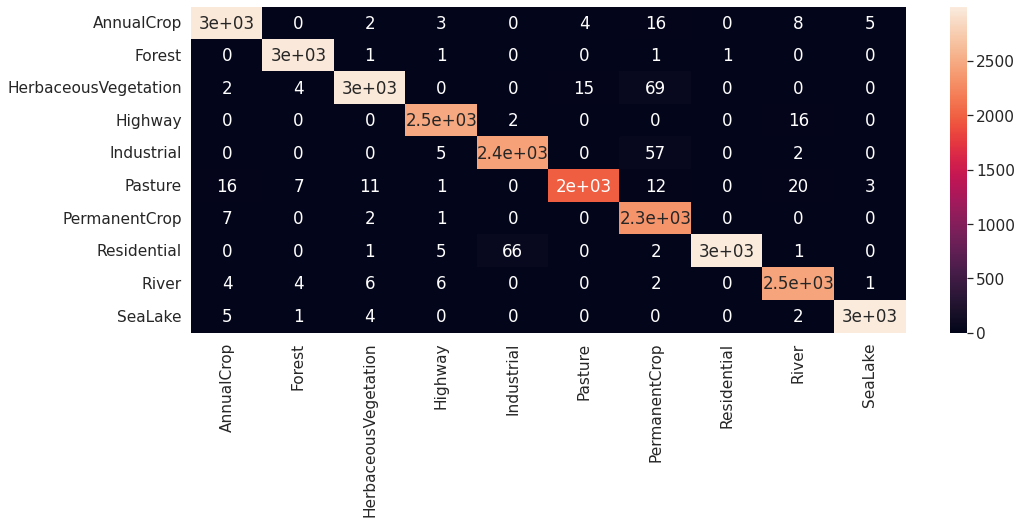

In [ ]:
## Plotting Confusion matrix
df_cm = pd.DataFrame(cm, CLASSES, CLASSES)
sns.set(font_scale=1.4) # for label size
plt.figure(figsize = (16,6))
sns.heatmap(df_cm, annot=True)